# Linear inverse solutions in NumPy: 2D

Reproducing Mauricio Sacchi's [GEOPH 431 and 531 tutorial on linear inversion](https://www.ualberta.ca/~msacchi/GEOPH431_531/linear_intro.pdf), which was written in MATLAB. Mauricio's version is also recorded at SubSurfWiki on the [Linear inversion chrestomathy](http://www.subsurfwiki.org/wiki/Linear_inversion_chrestomathy) page.

This version of the notebook solves the same problem, but in 2D. It then goes on to look at a different model, also in 2D. The math is all exactly the same.

**NB For the `@` notation to work (matrix mulitplication) you need Python 3.5 and Numpy 1.11.**

First, the usual preliminaries.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
def plot_all(m, d, m_est, d_pred):
    """
    Helper function for plotting. You can ignore this.
    """
    fig = plt.figure(figsize=(10,6))

    ax0 = fig.add_subplot(2,2,1)
    ax0.imshow(m, cmap='viridis', aspect='auto')
    ax0.set_title("$\mathrm{Model}\ m$")

    ax1 = fig.add_subplot(2,2,2)
    ax1.imshow(d, cmap='viridis', aspect='auto')
    ax1.set_title("$\mathrm{Data}\ d$")

    ax2 = fig.add_subplot(2,2,3)
    ax2.imshow(m_est, cmap='viridis', aspect='auto')
    ax2.set_title("$\mathrm{Estimated\ model}\ m_\mathrm{est}$")

    ax3 = fig.add_subplot(2,2,4)
    ax3.imshow(d_pred, cmap='viridis', aspect='auto')
    ax3.set_title("$\mathrm{Predicted\ data}\ d_\mathrm{pred}$")

    plt.show()

In [3]:
import scipy.linalg

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return scipy.linalg.toeplitz(col_1, row_1)

## Mauricio's 1D problem in 2D

We first define the model.

In [4]:
M = 50
m = np.zeros((M+1, 1))  # Have to do +1 because we're going to lose one in computing RC series.
m[10:15,:] = 1.0
m[15:27,:] = -0.3
m[27:35,:] = 2.1

In [6]:
m = (m[1:] - m[:-1]) / (m[1:] + m[:-1] + 1e-9)  # Small number avoid division by zero.

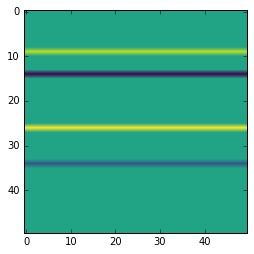

In [7]:
m = np.repeat(m, 50, axis=-1)
plt.imshow(m, cmap='viridis')

Form the discrete kernel, *G*.

In [8]:
N = 20
L = 100
alpha = 0.08

x = np.arange(0, M, 1) * L/(M-1)
dx = L/(M-1)
r = np.arange(0, N, 1) * L/(N-1)

In [9]:
G = np.zeros((N, M))
for j in range(M):
    for k in range(N):
        G[k,j] = dx * np.exp(-alpha * np.abs(r[k] - x[j])**2)

Compute the data; this is the forward problem.

In [10]:
d = G @ m

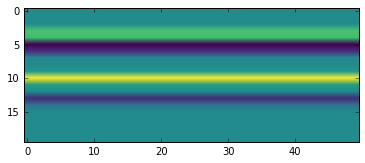

In [11]:
plt.imshow(d, cmap='viridis')

Minimum least squares solution:

In [12]:
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

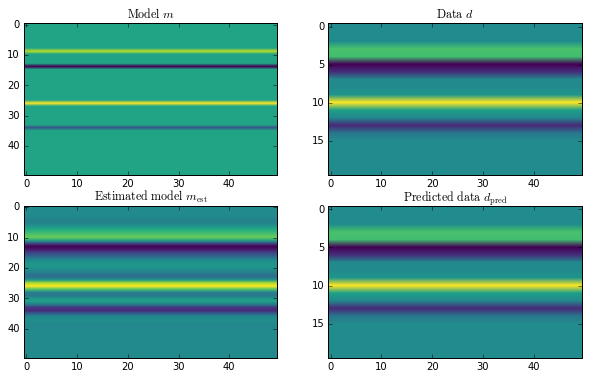

In [13]:
plot_all(m, d, m_est, d_pred)

We can also just use NumPy's solver directly.

In [14]:
m_est = la.lstsq(G, d)[0]
d_pred = G @ m_est

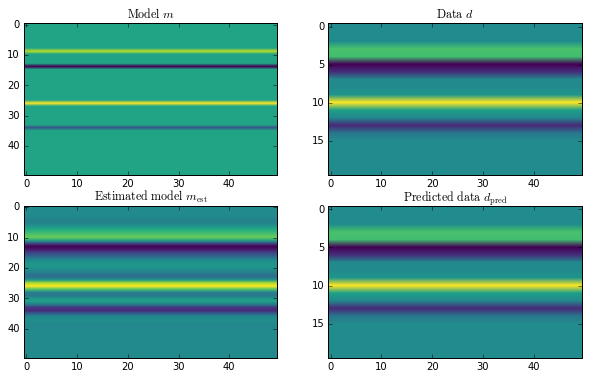

In [15]:
plot_all(m, d, m_est, d_pred)

## More complex models

In [16]:
from io import BytesIO
import requests
from urllib.parse import quote

text = '+ ='
url = "https://chart.googleapis.com/chart"
params = {'chst': 'd_text_outline',
          'chld': '000000|36|h|000000|_|{}'.format(text),
         }

r = requests.get(url, params)
b = BytesIO(r.content)

In [17]:
img = mpimg.imread(b)

In [18]:
m = np.pad(img[...,3], 20, 'constant')

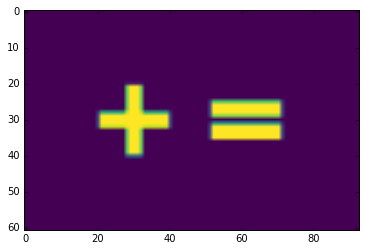

In [19]:
plt.imshow(m, cmap='viridis')

In [20]:
m = (m[1:] - m[:-1]) / (m[1:] + m[:-1] + 1e-9)  # Small number avoid division by zero.

I changed the shape of *m* so we have to make a new *G*.

In [21]:
M = m.shape[0]
N = 20
L = 100
alpha = 0.08

x = np.arange(0, M, 1) * L/(M-1)
dx = L/(M-1)
r = np.arange(0, N, 1) * L/(N-1)

In [22]:
G = np.zeros((N, M))
for j in range(M):
    for k in range(N):
        G[k,j] = dx * np.exp(-alpha * np.abs(r[k] - x[j])**2)

Forward model the data.

In [23]:
d = G @ m

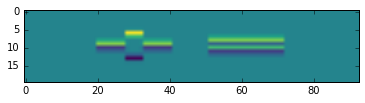

In [24]:
plt.imshow(d, cmap='viridis')

## Noise-free: minimum norm

In [25]:
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

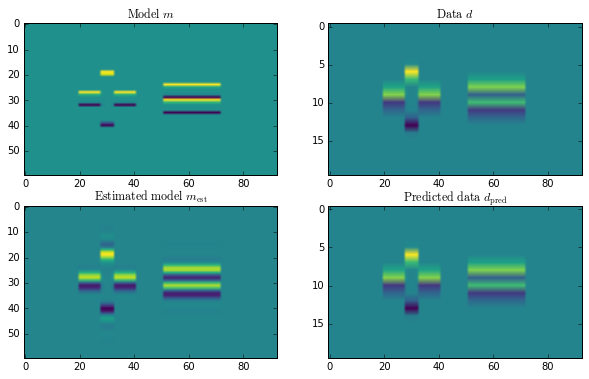

In [26]:
plot_all(m, d, m_est, d_pred)

## Solve with LAPACK

In [27]:
m_est = la.lstsq(G, d)[0]
d_pred = G @ m_est

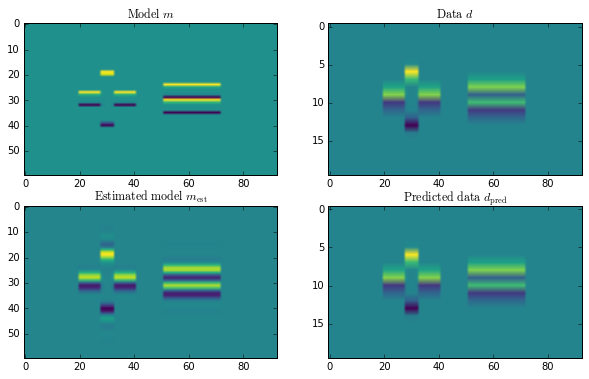

In [28]:
plot_all(m, d, m_est, d_pred)

## With noise: damped least squares

In [29]:
s = 1
d += s * np.random.random(d.shape)

In [30]:
I = np.eye(N)
µ = 2.5
m_est = G.T @ la.inv(G @ G.T + µ * I) @ d
d_pred = G @ m_est

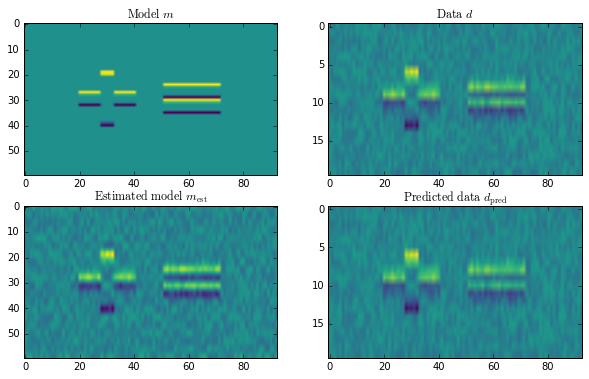

In [31]:
plot_all(m, d, m_est, d_pred)

## With noise: damped least squares with first derivative regularization

In [32]:
W = convmtx([1,-1], M)[:,:-1]  # Skip last column

Now we solve:

$$ \hat{\mathbf{m}} = (\mathbf{G}^\mathrm{T} \mathbf{G} + \mu \mathbf{W}^\mathrm{T} \mathbf{W})^{-1} \mathbf{G}^\mathrm{T} \mathbf{d} \ \ $$

In [33]:
m_est = la.inv(G.T @ G + µ * W.T @ W) @ G.T @ d
d_pred = G @ m_est

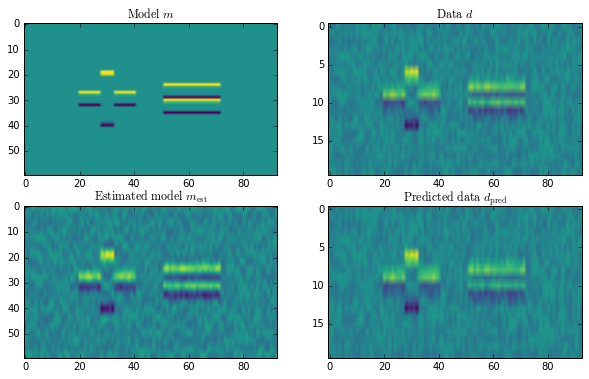

In [34]:
plot_all(m, d, m_est, d_pred)